In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy

In [27]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

#sns.set_style('white')
plt.style.use('dark_background')

In [28]:
def compute_usage(df):
    onsets = np.where(np.diff(df['syllables']) != 0)[0]
    usage = df.loc[df.index[onsets], 'syllables'].value_counts(normalize=True)
    return usage

In [29]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllables']).mean()
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

In [ ]:
from scipy.spatial.distance import pdist, squareform


In [31]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_females.parquet')
df = pd.read_parquet(path)

In [32]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [33]:
# calculate usage
fusages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
fusage_mtx = pd.pivot_table(fusages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
fusage_mtx.columns = fusage_mtx.columns.droplevel(0)

#filter most used syllables just females
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [34]:
fdf_all = fusage_mtx.copy()

In [35]:
#get random 16 mice per age
n=16
fdf_all = fdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [36]:
## upload data frame males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_males.parquet')
df = pd.read_parquet(path)

In [37]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [38]:
# calculate usage
musages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
musage_mtx = pd.pivot_table(musages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
musage_mtx.columns = musage_mtx.columns.droplevel(0)

#filter most used syllables just males
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [39]:
mdf_all = musage_mtx.copy()

In [40]:
#get random 16 mice per age
n=16
mdf_all = mdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [41]:
# filter by use of both sexes
combined_df = pd.concat([musages,fusages]).fillna(0)
include_syll = syll_index_above_threshold(combined_df)
mdf = mdf_all[include_syll]
fdf = fdf_all[include_syll]

In [42]:
## entropy calculations

In [1]:
# get average syllable change over age
mean_su = mdf.groupby('age').mean()
cmg=sns.clustermap(mean_su.to_numpy(),
                   col_cluster=True,row_cluster=None,
                   method='average',
                   metric='jensenshannon',
                   )
s=cmg.dendrogram_col.reordered_ind #reordered columns of the matrix

NameError: name 'mdf' is not defined

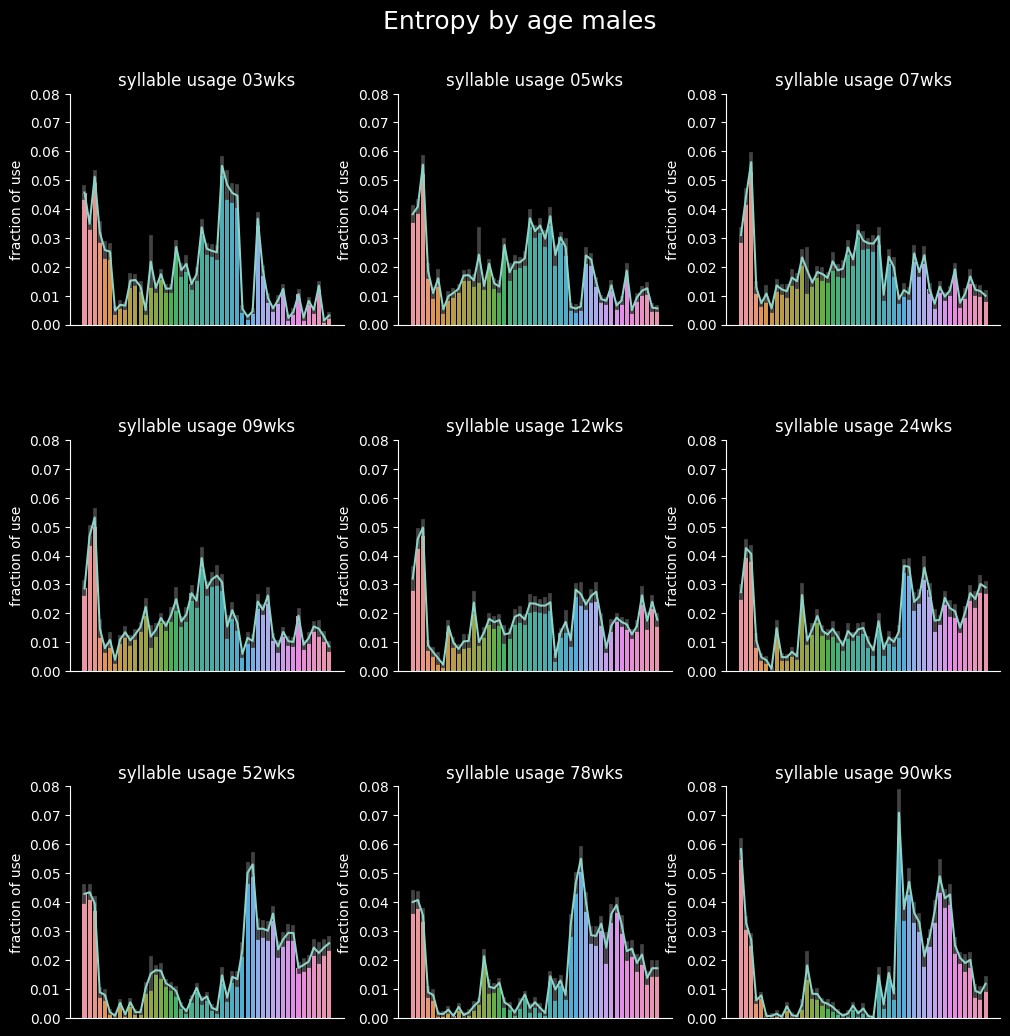

In [47]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age males", fontsize=18, y=0.95)

n=0
ages=[]
ent=[]
exp=[]
for age,_df in enumerate(mdf.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(_df[1].index.get_level_values(2).to_numpy())
    data_temp = _df[1].to_numpy()[:,s]
    #data_temp = _df[1].to_numpy()
    ent.extend(scipy.stats.entropy(data_temp, axis=1))
    #fig, ax = plt.subplots()
    #fig.set_size_inches(6,4)
    ax = plt.subplot(3, 3, n + 1)
    sns.barplot(data_temp, errorbar='se',ax=ax)
    sns.lineplot(np.mean(data_temp, axis=0),ax=ax)
    ax.set_title('syllable usage ' + str(_df[1].index.get_level_values(0).unique().to_numpy()[0]))
    ax.set_ylim(0,0.08)
    ax.set_xticks([])
    ax.set_ylabel('fraction of use')
    n=n+1
    sns.despine()
plt.savefig(data_loc +'ontogeny_entropy_male_examples.pdf', bbox_inches='tight')


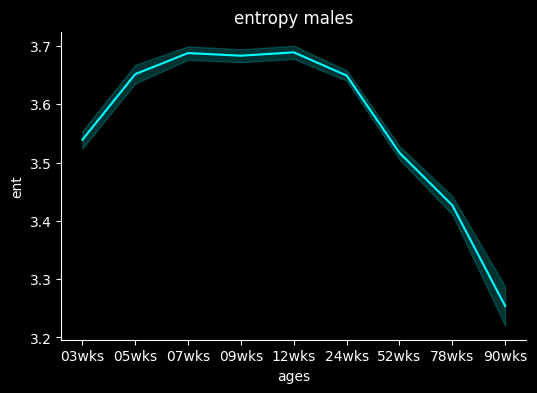

In [48]:
# plot entropy values
df=pd.DataFrame()
df['ages']=ages
df['ent']=ent
df['exp']=exp
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=df, x="ages", y="ent", estimator='mean', errorbar='se', c='cyan')
ax.set_title('entropy males')
#ax.set_ylim(0.0015,0.003)
em = df.copy()
sns.despine()
plt.savefig(data_loc +'ontogeny_entropy_male_line.pdf', bbox_inches='tight')

In [49]:
## for females

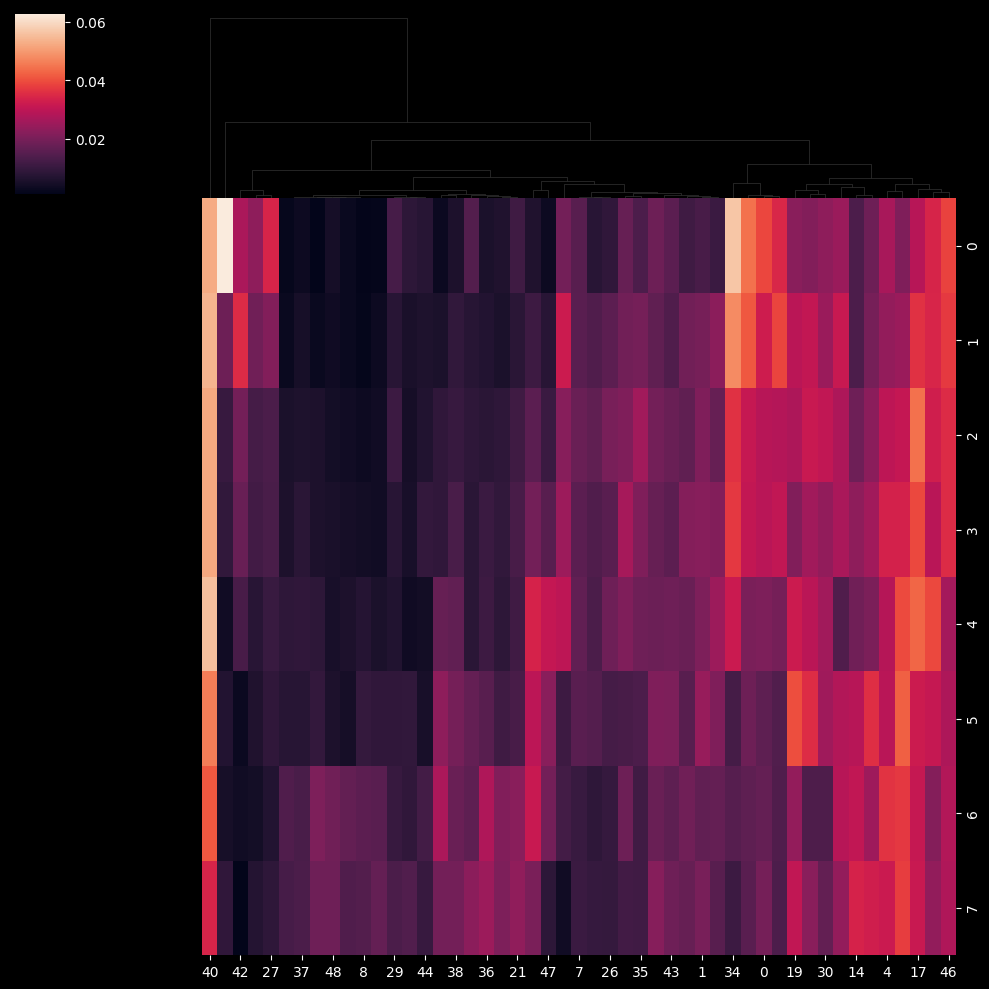

In [50]:
# get average syllable change over age
mean_su = fdf.groupby('age').mean()
cmg=sns.clustermap(mean_su.to_numpy(),
                   col_cluster=True,row_cluster=None,
                   method='average',
                   metric='sqeuclidean',
                   )
s=cmg.dendrogram_col.reordered_ind #reordered columns of the matrix

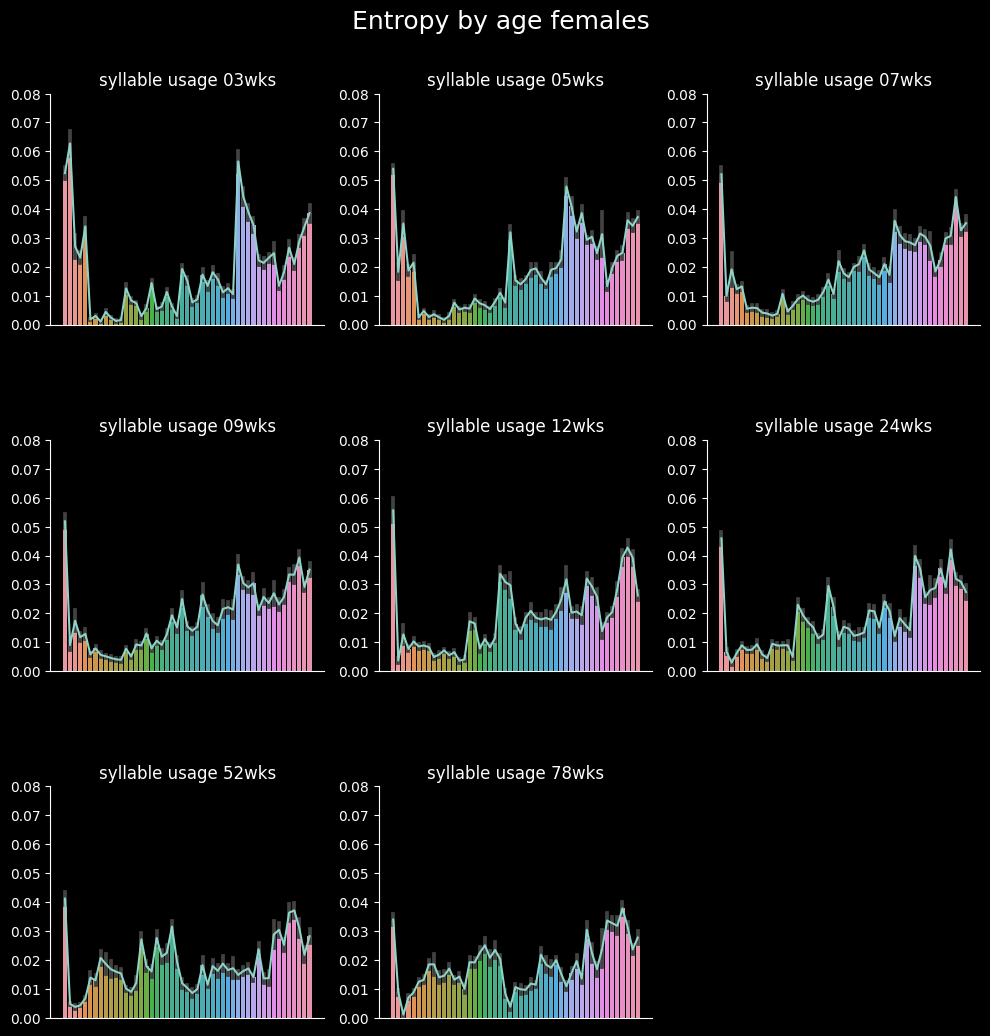

In [54]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Entropy by age females", fontsize=18, y=0.95)

n=0
ages=[]
ent=[]
exp=[]
for age,_df in enumerate(fdf.groupby('age')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(_df[1].index.get_level_values(2).to_numpy())
    data_temp = _df[1].to_numpy()[:,s]
    #data_temp = _df[1].to_numpy()
    ent.extend(scipy.stats.entropy(data_temp, axis=1))
    #fig, ax = plt.subplots()
    #fig.set_size_inches(6,4)
    ax = plt.subplot(3, 3, n + 1)
    sns.barplot(data_temp, errorbar='se',ax=ax)
    sns.lineplot(np.mean(data_temp, axis=0),ax=ax)
    ax.set_title('syllable usage ' + str(_df[1].index.get_level_values(0).unique().to_numpy()[0]))
    ax.set_ylim(0,0.08)
    ax.set_xticks([])
    n=n+1
    sns.despine()
plt.savefig(data_loc +'ontogeny_entropy_female_examples.pdf', bbox_inches='tight')

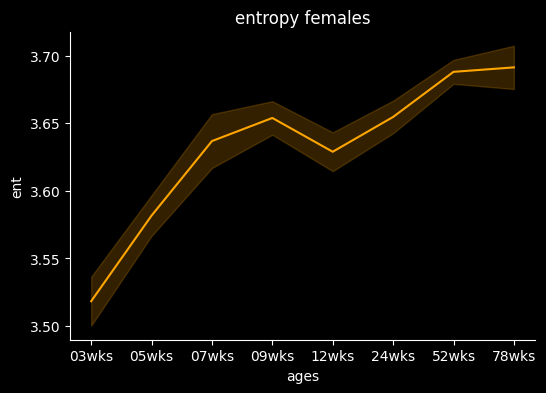

In [52]:
# plot entropy values
df=pd.DataFrame()
df['ages']=ages
df['ent']=ent
df['exp']=exp
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=df, x="ages", y="ent", estimator='mean', errorbar='se',c='orange')
ax.set_title('entropy females')
#ax.set_ylim(0.0015,0.003)
ef = df.copy()
sns.despine()
plt.savefig(data_loc +'ontogeny_entropy_female_line.pdf', bbox_inches='tight')

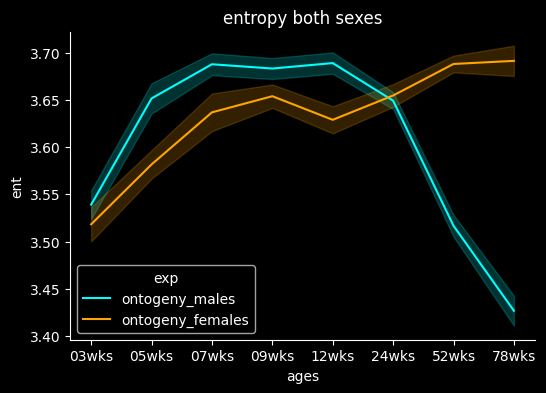

In [53]:
combined=pd.concat([em,ef])
combined=combined[~(combined.ages=='90wks')]
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=combined, x="ages", y="ent", hue='exp', estimator='mean', errorbar='se',palette = ['cyan','orange'],)
ax.set_title('entropy both sexes')
sns.despine()
#ax.set_ylim(0.0015,0.003)
plt.savefig(data_loc +'ontogeny_entropy_mf_line.pdf', bbox_inches='tight')